### Convolutional neural network using Tensorflow Functional API
<br><br />
This exercise is to implement a CNN which is very similar to the *LeNet-5* network made to identify hand written digits from the [MNIST database](http://yann.lecun.com/exdb/mnist/). The database was converted to a matlab file externally and imported as it is here.

Here *Tensorflow* data.Dataset API is also used to create a training dataset much like you would do on cloud for a data pipeline.<br><br />

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

MNIST database example digit:  6


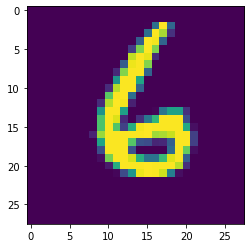

In [8]:
d = sio.loadmat("mnist.mat")

# -- 60,000 training samples --
im = d['trainX']  # (60000, 784) -- images
lb = d['trainY']  # (1, 60000) -- labels

# -- 10,000 test samples --
im_test = d['testX']  # (10000, 784) -- test images
lb_test = d['testY']  # (1, 10000) -- test labels

n = np.random.randint(0,high=len(im))

# -- labelled sample from dataset --
print('MNIST database example digit: ', lb[0,n])
plt.imshow(im[n].reshape(28,28))
plt.show()

In [9]:
print(im.shape)

(60000, 784)


For data augumentation using elastic distortion, we use the following implementation by [fmder](https://gist.github.com/fmder/e28813c1e8721830ff9c) for square images.

In [4]:
## -- elastic distortions function definition --

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), 
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), 
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

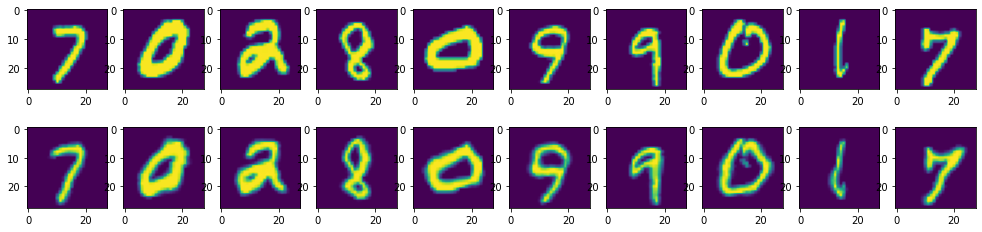

In [10]:
## -- elastic distorted image example --
rows = 1
cols = 10
alpha = 12
sigma = 2.8
fig, axes = plt.subplots(ncols=cols, nrows=rows*2, figsize=(17,4))
for i in range(rows*cols):
    n =  np.random.randint(0,high=len(im))
    im_d = elastic_transform(im[n].reshape(28,28), alpha, sigma)

    axes[0,i].imshow(im[n].reshape(28,28))
    axes[1,i].imshow(im_d.reshape(28,28))
plt.show()

In [11]:
## -- creating distorted dataset portion --
im_dist = np.zeros(im.shape)
for i,pic in enumerate(im):
    pic_dist = elastic_transform(pic.reshape(28,28), alpha, sigma)
    im_dist[i] = pic_dist.reshape(-1,784)

MNIST database example digit:  2


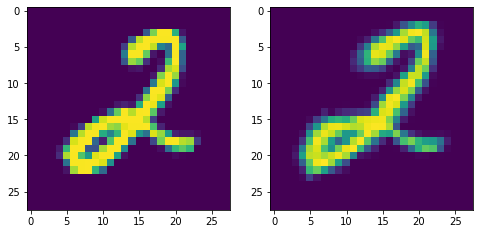

(60000, 784)
(120000, 784)
(2, 60000)


In [12]:
# -- labelled sample from dataset --
n = np.random.randint(0,high=len(im))

print('MNIST database example digit: ', lb[0,n])
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
axes[0].imshow(im[n].reshape(28,28))
axes[1].imshow(im_dist[n].reshape(28,28))
plt.show()

im_train = np.concatenate((im, im_dist))
lb_train = np.concatenate((lb, lb))
print(im.shape)
print(im_train.shape)
print(lb_train.shape)

In [13]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
tf.__version__

'2.3.0'

In [38]:
## -- CNN model architecture using TF Functional API --

# -- input layer
in_put = tf.keras.Input(shape=(28,28,1), name='input_layer')
# -- 2D conv layer
im_conv1 = tf.keras.layers.Conv2D( name = 'conv1',
    filters=32,
    kernel_size=5,
    activation='relu',
    padding='same'
)(in_put)
# -- max pooling layer
pool1 = tf.keras.layers.MaxPool2D( name = 'pool1',
    pool_size=(2, 2),
)(im_conv1)

# -- 2D conv layer
im_conv2 = tf.keras.layers.Conv2D( name = 'conv2',
    filters=64,
    kernel_size=5,
    activation='relu',
#     padding='same'
)(pool1)
# -- max pooling layer
pool2 = tf.keras.layers.MaxPool2D( name = 'pool2',
    pool_size=(2, 2),
)(im_conv2)

# -- dense layers
flat = tf.keras.layers.Flatten(name='flat1')(pool2)
a = tf.keras.layers.Dense(240, activation='relu', name='dense1')(flat)
# b = tf.keras.layers.Dense(80, activation='relu', name='dense3')(a)
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(a)

model = tf.keras.Model(in_put, output)

In [39]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 64)        51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 64)          0         
_________________________________________________________________
flat1 (Flatten)              (None, 1600)              0         
_________________________________________________________________
dense1 (Dense)               (None, 240)              

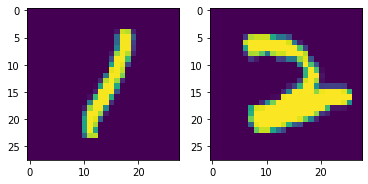

In [40]:
## -- creating datasets using TF Dataset API --


BATCH_SIZE = 100
dataset = tf.data.Dataset.from_tensor_slices(((im_train/255.).reshape(-1,28,28,1), 
                                              to_categorical(lb_train.reshape(-1,1))))

dataset = dataset.shuffle(len(im), reshuffle_each_iteration=True).batch(BATCH_SIZE)

# -- validation set --
testset = tf.data.Dataset.from_tensor_slices(((im_test/255.).reshape(-1,28,28,1), 
                                              to_categorical(lb_test.reshape(-1,1))))
testset = testset.batch(4)

# -- plotting two examples from the shuffled dataset
fig, axes = plt.subplots(ncols=2, nrows=1)
for n,i in enumerate(dataset.take(2)):
    axes[n].imshow(i[0][0])
plt.show()

testset = tf.data.Dataset.from_tensor_slices(((im_test/255.).reshape(-1,28,28,1), 
                                              to_categorical(lb_test.reshape(-1,1)))).batch(1)

In [18]:
print(dataset.take(1))
print(testset.take(1))

<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float64, tf.float32)>
<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float64, tf.float32)>


In [41]:
## -- compiling and training the model --
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

history = model.fit(dataset, 
                   epochs=8,
                   validation_data=testset,
                   )

Epoch 1/8
1200/1200 [==============================] - 125s 104ms/step - loss: 0.1209 - accuracy: 0.9623 - val_loss: 0.0277 - val_accuracy: 0.9900
Epoch 2/8
1200/1200 [==============================] - 123s 103ms/step - loss: 0.0408 - accuracy: 0.9870 - val_loss: 0.0201 - val_accuracy: 0.9930
Epoch 3/8
1200/1200 [==============================] - 121s 101ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 0.0293 - val_accuracy: 0.9914
Epoch 4/8
1200/1200 [==============================] - 129s 107ms/step - loss: 0.0211 - accuracy: 0.9929 - val_loss: 0.0227 - val_accuracy: 0.9923
Epoch 5/8
1200/1200 [==============================] - 128s 107ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.0197 - val_accuracy: 0.9938
Epoch 6/8
1200/1200 [==============================] - 118s 99ms/step - loss: 0.0124 - accuracy: 0.9958 - val_loss: 0.0206 - val_accuracy: 0.9938
Epoch 7/8
1200/1200 [==============================] - 121s 101ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.

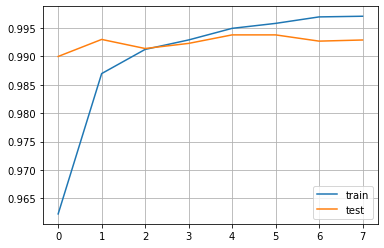

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
plt.show()

<br />

So the CNN performs close (~99.4%) to what the original paper reports (Simard et al 2003) using elastic distortions (99.6% accuracy).

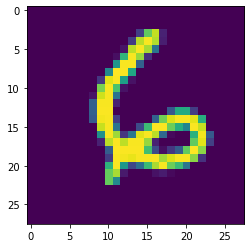

Answer: 6


In [44]:
## -- random output prediction --

n = np.random.randint(0,high=10000)

x = np.array(im_test[n]/255)
x = x.reshape(-1,28,28,1)

plt.imshow(x[0])
plt.show()

print(f'Answer: {np.argmax(model.predict(x))}')

In [45]:
## -- getting filter output from first convolution layer --
layer_name = 'conv1'
intm_layer_model = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
intm_output = intm_layer_model(x)

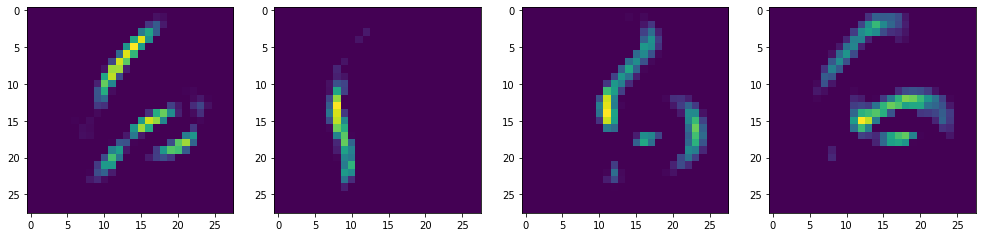

In [46]:
# -- plotting 1st convolutional layer sample features --

cols = 4
rows = 1
fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(17,4))
index = 0
for j in range(cols):
    axes[j].imshow(intm_output[0][:,:,index])
    index += 1
plt.show()